# **Etapa 1:** Importação de Bibliotecas e Leitura dos Dados

📌 Descrição da etapa

Nesta etapa inicial, configurei o ambiente analítico utilizando PySpark, que será o motor principal de processamento de dados devido ao volume e à natureza distribuída dos datasets.
Também importei bibliotecas auxiliares para análises estatísticas, visualizações e validações complementares.

Em seguida, realizei a leitura dos dados brutos fornecidos no case, provenientes de datasets disponibilizados, garantindo que estejam disponíveis em DataFrames Spark para as próximas etapas do pipeline.

📦 **Importação de bibliotecas**

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import col, sum as spark_sum, least, when
from pyspark.sql.functions import (
    min as spark_min, max as spark_max, col, sum, avg, countDistinct, lit,
    from_json, explode, datediff, current_date, expr, mean,
    percentile_approx, count, isnan, when
)
from pyspark.sql.window import Window
from pyspark.sql.functions import (
    col, count, countDistinct, avg, sum as spark_sum,
    min, max, datediff, round as spark_round, first
)
from pyspark.sql.types import (
    DoubleType, IntegerType, StringType, StructType,
    StructField, ArrayType, BooleanType, LongType, FloatType
)
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import ClusteringEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import tarfile
import gzip
import shutil
import builtins
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind, mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import calinski_harabasz_score

🔧 **Inicialização da Spark Session**

In [2]:
os.environ["PYSPARK_SUBMIT_ARGS"] = "--driver-memory 8g pyspark-shell"

spark = (
    SparkSession.builder
    .appName("ifood_ab_test_analysis")
    .getOrCreate()
)

# **Etapa 2:** Extração, Transformação e Carga (ETL)

📌 Descrição da etapa

Nesta etapa realizei o processo de ETL (Extract, Transform, Load), que consiste em:

- **Extração:** seleção apenas dos dados relevantes para o experimento, incluindo pedidos, clientes, restaurantes e marcação do teste A/B.

- **Transformação:** limpeza, padronização e criação de variáveis analíticas, como métricas de pedidos por usuário, datas e indicadores de gasto.

- **Carga:** consolidação dos dados em uma base única, pronta para análise, garantindo que cada usuário esteja corretamente alocado no grupo teste ou controle.

🎯 **Objetivo:** construir uma tabela analítica, respeitando o desenho experimental do teste A/B e permitindo medir com precisão o impacto da campanha de cupons.

📂 **Leitura dos dados**

In [3]:
# Links dos arquivos

urls = {
    "order.json.gz": "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/order.json.gz",
    "consumer.csv.gz": "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/consumer.csv.gz",
    "restaurant.csv.gz": "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/restaurant.csv.gz",
    "ab_test_ref.tar.gz": "https://data-architect-test-source.s3-sa-east-1.amazonaws.com/ab_test_ref.tar.gz"
}

# Criar diretório

os.makedirs("data", exist_ok=True)

# Baixar arquivos

for filename, url in urls.items():
    # Usar -nc para não sobrescrever arquivos existentes se já baixados
    os.system(f"wget -nc -O data/{filename} {url}")

# Extrair o .tar.gz

with tarfile.open("data/ab_test_ref.tar.gz", "r:gz") as tar:
    tar.extractall(path="data")

# Descompactar os .gz (JSON e CSV)

for fname in ["order.json.gz", "consumer.csv.gz", "restaurant.csv.gz"]:
    with gzip.open(f"data/{fname}", "rb") as f_in:
        with open(f"data/{fname[:-3]}", "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

/tmp/ipython-input-3591330040.py:23: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path="data")


In [4]:
orders = spark.read.json("data/order.json")
consumers = spark.read.option("header", True).csv("data/consumer.csv")
restaurants = spark.read.option("header", True).csv("data/restaurant.csv")
ab_test = spark.read.option("header", True).csv("data/ab_test_ref.csv")

🔍 **Validação inicial das bases**

In [5]:
print('Quantidade de Resgistros:')

print("Pedidos:", orders.count())
print("Clientes:", consumers.count())
print("Restaurantes:", restaurants.count())
print("Testes A/B:", ab_test.count())

Quantidade de Resgistros:
Pedidos: 3670826
Clientes: 806156
Restaurantes: 7292
Testes A/B: 806467


In [6]:
print('Schema dos Dados:')

print("Pedidos:", orders.printSchema())
print("Clientes:", consumers.printSchema())
print("Restaurantes:", restaurants.printSchema())
print("Testes A/B:", ab_test.printSchema())

Schema dos Dados:
root
 |-- cpf: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- delivery_address_city: string (nullable = true)
 |-- delivery_address_country: string (nullable = true)
 |-- delivery_address_district: string (nullable = true)
 |-- delivery_address_external_id: string (nullable = true)
 |-- delivery_address_latitude: string (nullable = true)
 |-- delivery_address_longitude: string (nullable = true)
 |-- delivery_address_state: string (nullable = true)
 |-- delivery_address_zip_code: string (nullable = true)
 |-- items: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- merchant_latitude: string (nullable = true)
 |-- merchant_longitude: string (nullable = true)
 |-- merchant_timezone: string (nullable = true)
 |-- order_created_at: string (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_scheduled: boolean (nullable = true)
 |-- order_scheduled_date: string (nul

In [7]:
def validate_unique_key(df, key_cols, table_name):
    total_rows = df.count()
    distinct_rows = df.select(key_cols).distinct().count()

    print(f"--- Validação de chave única | {table_name} ---")
    print(f"Total de linhas: {total_rows}")
    print(f"Valores distintos da chave: {distinct_rows}")

    if total_rows == distinct_rows:
        print("✅ Chave única garantida\n")
    else:
        print("❌ Existem duplicidades na chave\n")

validate_unique_key(orders, ["order_id"], "Pedidos")
validate_unique_key(consumers, ["customer_id"], "Clientes")
validate_unique_key(restaurants, ["id"], "Restaurantes")
validate_unique_key(ab_test, ["customer_id"], "Teste A/B")

--- Validação de chave única | Pedidos ---
Total de linhas: 3670826
Valores distintos da chave: 2432974
❌ Existem duplicidades na chave

--- Validação de chave única | Clientes ---
Total de linhas: 806156
Valores distintos da chave: 806156
✅ Chave única garantida

--- Validação de chave única | Restaurantes ---
Total de linhas: 7292
Valores distintos da chave: 7292
✅ Chave única garantida

--- Validação de chave única | Teste A/B ---
Total de linhas: 806467
Valores distintos da chave: 806467
✅ Chave única garantida



In [8]:
orders.groupBy("order_id").count().filter(col("count") > 1).show()

+--------------------+-----+
|            order_id|count|
+--------------------+-----+
|89695ff3738ee6bb2...|    2|
|992a7e396199dee94...|    2|
|95a197ed930258a1b...|    2|
|2153f0d7b0df1468a...|    2|
|d468466c13657db8d...|    2|
|34e0735ee46bb84f3...|    2|
|3eb4c5e8e99972cf8...|    2|
|8d6130dc644366749...|    2|
|c68dd25cae7efa1ad...|    2|
|cf3eeccf786179fc6...|    2|
|d4bc57afa9c156e5f...|    2|
|6681673356d0d40ff...|    2|
|abc992b1a6efb3a7f...|    2|
|da24ffc5b71b326a3...|    2|
|285f5344a6e6e4665...|    2|
|8936bdbd5fb205050...|    2|
|5dce73c93f2a827e9...|    2|
|f54f46a5d6bfe0afd...|    2|
|b2950419768227cd9...|    2|
|c8274a3e6071990d6...|    2|
+--------------------+-----+
only showing top 20 rows


In [9]:
orders = orders.withColumn(
    "order_sk",
    F.sha2(
        F.concat_ws(
            "|",
            col("order_id"),
            col("order_created_at"),
            col("customer_id")
        ),
        256
    )
)

validate_unique_key(orders, ["order_sk"], "Pedidos")

--- Validação de chave única | Pedidos ---
Total de linhas: 3670826
Valores distintos da chave: 3670826
✅ Chave única garantida



🔄 **Conversão de tipos das colunas**

In [10]:
orders = (
    orders
    .withColumn("delivery_address_latitude", col("delivery_address_latitude").cast("float"))
    .withColumn("delivery_address_longitude", col("delivery_address_longitude").cast("float"))
    .withColumn("merchant_latitude", col("merchant_latitude").cast("float"))
    .withColumn("merchant_longitude", col("merchant_longitude").cast("float"))
    .withColumn("order_total_amount", col("order_total_amount").cast("float"))
    .withColumn("order_created_at", col("order_created_at").cast("timestamp"))
    .withColumn("order_scheduled_date", col("order_scheduled_date").cast("timestamp"))
    .withColumn("order_scheduled", col("order_scheduled").cast("boolean"))
)

orders.printSchema()
orders.show(5, truncate=False)

root
 |-- cpf: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- delivery_address_city: string (nullable = true)
 |-- delivery_address_country: string (nullable = true)
 |-- delivery_address_district: string (nullable = true)
 |-- delivery_address_external_id: string (nullable = true)
 |-- delivery_address_latitude: float (nullable = true)
 |-- delivery_address_longitude: float (nullable = true)
 |-- delivery_address_state: string (nullable = true)
 |-- delivery_address_zip_code: string (nullable = true)
 |-- items: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- merchant_latitude: float (nullable = true)
 |-- merchant_longitude: float (nullable = true)
 |-- merchant_timezone: string (nullable = true)
 |-- order_created_at: timestamp (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_scheduled: boolean (nullable = true)
 |-- order_scheduled_date: timestamp (nullable = true)
 |

In [11]:
consumers = (
    consumers
    .withColumn("created_at", col("created_at").cast("timestamp"))
    .withColumn("active", col("active").cast("boolean"))
)

consumers.printSchema()
consumers.show(5, truncate=False)

root
 |-- customer_id: string (nullable = true)
 |-- language: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- active: boolean (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- customer_phone_area: string (nullable = true)
 |-- customer_phone_number: string (nullable = true)

+----------------------------------------------------------------+--------+-----------------------+------+-------------+-------------------+---------------------+
|customer_id                                                     |language|created_at             |active|customer_name|customer_phone_area|customer_phone_number|
+----------------------------------------------------------------+--------+-----------------------+------+-------------+-------------------+---------------------+
|e8cc60860e09c0bb19610b06ced69c973eb83982cfc98e397ce65cba92f70928|pt-br   |2018-04-05 14:49:18.165|true  |NUNO         |46                 |816135924            |
|a2834a38a9876cf74e016524d

In [12]:
restaurants = (
    restaurants
    .withColumn("created_at", col("created_at").cast("timestamp"))
    .withColumn("enabled", col("enabled").cast("boolean"))
    .withColumn("price_range", col("price_range").cast("int"))
    .withColumn("average_ticket", col("average_ticket").cast("float"))
    .withColumn("delivery_time", col("delivery_time").cast("float"))
    .withColumn("minimum_order_value", col("minimum_order_value").cast("float"))
)

restaurants.printSchema()
restaurants.show(5, truncate=False)

root
 |-- id: string (nullable = true)
 |-- created_at: timestamp (nullable = true)
 |-- enabled: boolean (nullable = true)
 |-- price_range: integer (nullable = true)
 |-- average_ticket: float (nullable = true)
 |-- takeout_time: string (nullable = true)
 |-- delivery_time: float (nullable = true)
 |-- minimum_order_value: float (nullable = true)
 |-- merchant_zip_code: string (nullable = true)
 |-- merchant_city: string (nullable = true)
 |-- merchant_state: string (nullable = true)
 |-- merchant_country: string (nullable = true)

+----------------------------------------------------------------+-----------------------+-------+-----------+--------------+------------+-------------+-------------------+-----------------+--------------+--------------+----------------+
|id                                                              |created_at             |enabled|price_range|average_ticket|takeout_time|delivery_time|minimum_order_value|merchant_zip_code|merchant_city |merchant_state|me

✍️

Após as validações iniciais, realizei a padronização dos tipos de dados das colunas, ajustando formatações de datas, valores numéricos e campos booleanos, de modo a garantir total aderência ao dicionário de dados e ao documento técnico fornecido no case.

Além disso, validei a integridade dos datasets, confirmando que a quantidade de registros em cada tabela está de acordo com o esperado, conforme especificado na documentação enviada. Essa verificação assegura que não houve perdas, duplicações ou inconsistências durante o processo de ingestão e transformação dos dados. Cada uma das tabelas também possui uma chave única.

# **Etapa 2.1:** Análise Exploratória dos Dados

📌 Descrição da etapa

Nesta etapa, realizei uma análise exploratória aprofundada com o objetivo de:

- Compreender o comportamento dos clientes

- Identificar padrões de pedidos e gasto

- Avaliar outliers e assimetrias

- Investigar possíveis diferenças iniciais entre grupos do teste A/B

- Garantir que os dados estejam adequados para análises estatísticas posteriores

In [13]:
def show_df_info(df, name):
    print(f"--- {name} ---")
    print(f"Total de linhas: {df.count()}")
    df.show(5, truncate=False)
    print("\n")

print('Amostra das 5 primeiras linhas de cada tabela')

show_df_info(orders, "Pedidos")
show_df_info(consumers, "Clientes")
show_df_info(restaurants, "Restaurantes")
show_df_info(ab_test, "Testes A/B")

Amostra das 5 primeiras linhas de cada tabela
--- Pedidos ---
Total de linhas: 3670826
+-----------+----------------------------------------------------------------+-------------+---------------------+------------------------+-------------------------+----------------------------+-------------------------+--------------------------+----------------------+-------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [14]:
def null_count_percentage(df, name):
    print(f"--- {name}: Contagem e % de valores nulos ---")
    total_rows = df.count()

    exprs = []
    for c, dtype in df.dtypes:
        if dtype in ['float', 'double']:
            exprs.append(count(when(col(c).isNull() | isnan(col(c)), c)).alias(c))
        else:
            exprs.append(count(when(col(c).isNull(), c)).alias(c))

    result = df.select(exprs).toPandas().T.rename(columns={0: "nulos"})
    result["percentual"] = round(result["nulos"] / total_rows * 100, 2)

    display(result)
    print("\n")

null_count_percentage(orders, "Pedidos")
null_count_percentage(consumers, "Clientes")
null_count_percentage(restaurants, "Restaurantes")
null_count_percentage(ab_test, "Testes A/B")

--- Pedidos: Contagem e % de valores nulos ---


,nulos,percentual
cpf,0,0.00
customer_id,8505,0.23
customer_name,0,0.00
delivery_address_city,0,0.00
delivery_address_country,0,0.00
delivery_address_district,0,0.00
delivery_address_external_id,0,0.00
delivery_address_latitude,0,0.00
delivery_address_longitude,0,0.00
delivery_address_state,0,0.00




--- Clientes: Contagem e % de valores nulos ---


,nulos,percentual
customer_id,0,0.0
language,0,0.0
created_at,0,0.0
active,0,0.0
customer_name,0,0.0
customer_phone_area,0,0.0
customer_phone_number,0,0.0




--- Restaurantes: Contagem e % de valores nulos ---


,nulos,percentual
id,0,0.00
created_at,0,0.00
enabled,0,0.00
price_range,0,0.00
average_ticket,0,0.00
takeout_time,0,0.00
delivery_time,1,0.01
minimum_order_value,95,1.30
merchant_zip_code,0,0.00
merchant_city,0,0.00




--- Testes A/B: Contagem e % de valores nulos ---


,nulos,percentual
customer_id,0,0.0
is_target,0,0.0


In [15]:
def distinct_count_percentage(df, name):
    print(f"--- {name}: Valores distintos por coluna ---")
    total_rows = df.count()

    exprs = [countDistinct(col(c)).alias(c) for c in df.columns]

    result = df.select(exprs).toPandas().T.rename(columns={0: "valores_distintos"})
    result["percentual"] = round(result["valores_distintos"] / total_rows * 100, 2)

    display(result)
    print("\n")

distinct_count_percentage(orders, "Pedidos")
distinct_count_percentage(consumers, "Clientes")
distinct_count_percentage(restaurants, "Restaurantes")
distinct_count_percentage(ab_test, "Testes A/B")

--- Pedidos: Valores distintos por coluna ---


,valores_distintos,percentual
cpf,3670763,100.00
customer_id,806466,21.97
customer_name,47092,1.28
delivery_address_city,198,0.01
delivery_address_country,1,0.00
delivery_address_district,8359,0.23
delivery_address_external_id,1020634,27.80
delivery_address_latitude,894,0.02
delivery_address_longitude,914,0.02
delivery_address_state,23,0.00




--- Clientes: Valores distintos por coluna ---


,valores_distintos,percentual
customer_id,806156,100.00
language,2,0.00
created_at,494926,61.39
active,2,0.00
customer_name,47024,5.83
customer_phone_area,100,0.01
customer_phone_number,805838,99.96




--- Restaurantes: Valores distintos por coluna ---


,valores_distintos,percentual
id,7292,100.00
created_at,7292,100.00
enabled,2,0.03
price_range,5,0.07
average_ticket,11,0.15
takeout_time,17,0.23
delivery_time,53,0.73
minimum_order_value,130,1.78
merchant_zip_code,2927,40.14
merchant_city,157,2.15




--- Testes A/B: Valores distintos por coluna ---


,valores_distintos,percentual
customer_id,806467,100.0
is_target,2,0.0


In [16]:
def descriptive_statistics(df, name):
    print(f"--- {name}: Estatísticas descritivas (colunas numéricas) ---")

    numeric_cols = [c for c, t in df.dtypes if t in ['int', 'bigint', 'float', 'double']]

    if not numeric_cols:
        print("Não há colunas numéricas para análise.\n")
        return

    stats = df.select(numeric_cols).describe().toPandas().set_index('summary').T
    display(stats)
    print("\n")

descriptive_statistics(orders, "Pedidos")
descriptive_statistics(consumers, "Clientes")
descriptive_statistics(restaurants, "Restaurantes")
descriptive_statistics(ab_test, "Testes A/B")

--- Pedidos: Estatísticas descritivas (colunas numéricas) ---


summary,count,mean,stddev,min,max
delivery_address_latitude,3670826,-44.93203927703956,4.438217702923479,-73.67,0.0
delivery_address_longitude,3670826,-20.328647717636763,6.536103370219183,-30.22,38.71
merchant_latitude,3670826,-44.93203927703956,4.438217702923479,-73.67,0.0
merchant_longitude,3670826,-20.328647717636763,6.536103370219183,-30.22,38.71
order_total_amount,3670826,47.90005525991763,119.67385033845754,0.0,138750.9




--- Clientes: Estatísticas descritivas (colunas numéricas) ---
Não há colunas numéricas para análise.

--- Restaurantes: Estatísticas descritivas (colunas numéricas) ---


summary,count,mean,stddev,min,max
price_range,7292,2.561300054854635,1.1800935917985165,1,5
average_ticket,7292,53.72682391662095,19.56210313143663,0.0,100.0
delivery_time,7291,28.034974626251543,25.246657227480792,0.0,285.0
minimum_order_value,7197,28.7977587837833,1178.642726923184,0.0,100000.0




--- Testes A/B: Estatísticas descritivas (colunas numéricas) ---
Não há colunas numéricas para análise.



+-------+------------------+
|summary|order_total_amount|
+-------+------------------+
|  count|           3670826|
|   mean| 47.90005525991763|
| stddev|119.67385033845754|
|    min|               0.0|
|    max|          138750.9|
+-------+------------------+

+-------------------------------+
|percentis                      |
+-------------------------------+
|[26.9, 39.9, 57.4, 84.0, 176.0]|
+-------------------------------+



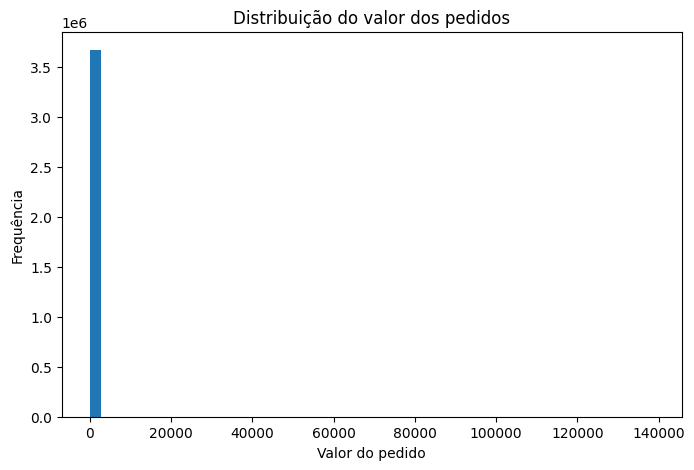

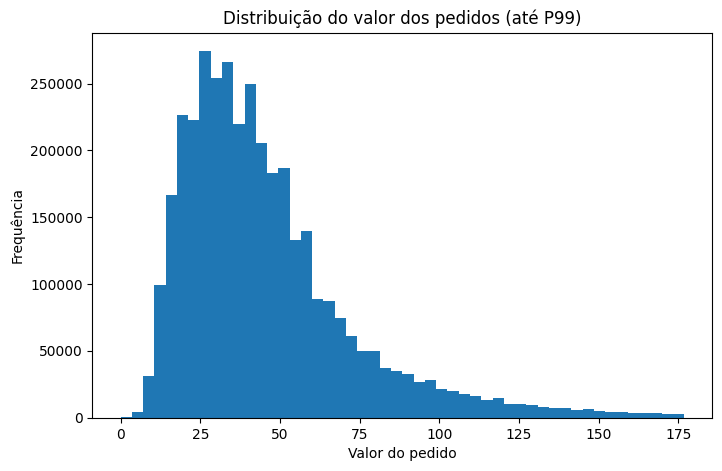

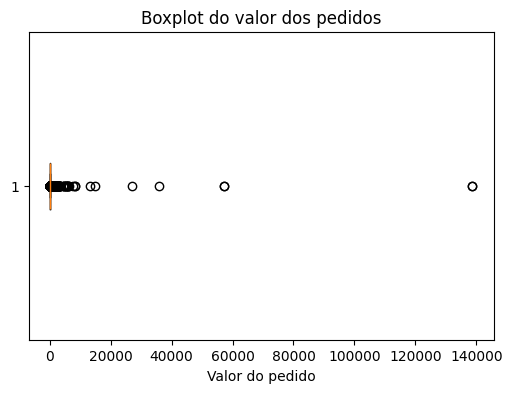

In [17]:
orders.select("order_total_amount").describe().show()

orders.select(
    percentile_approx(
        "order_total_amount",
        [0.25, 0.5, 0.75, 0.9, 0.99]
    ).alias("percentis")
).show(truncate=False)

order_amount_pd = (
    orders
    .select("order_total_amount")
    .dropna()
    .toPandas()
)

plt.figure(figsize=(8, 5))
plt.hist(order_amount_pd["order_total_amount"], bins=50)
plt.title("Distribuição do valor dos pedidos")
plt.xlabel("Valor do pedido")
plt.ylabel("Frequência")
plt.show()

p99 = order_amount_pd["order_total_amount"].quantile(0.99)

plt.figure(figsize=(8, 5))
plt.hist(
    order_amount_pd[
        order_amount_pd["order_total_amount"] <= p99
    ]["order_total_amount"],
    bins=50
)
plt.title("Distribuição do valor dos pedidos (até P99)")
plt.xlabel("Valor do pedido")
plt.ylabel("Frequência")
plt.show()

plt.figure(figsize=(6, 4))
plt.boxplot(order_amount_pd["order_total_amount"], vert=False)
plt.title("Boxplot do valor dos pedidos")
plt.xlabel("Valor do pedido")
plt.show()

📌 Tratamento de outliers - Método 1

Após a identificação de uma distribuição que não era normal em order_total_amount, foi aplicado um corte por percentil (P99), com exclusão física dos registros acima desse limiar.

Essa abordagem visa remover valores extremamente elevados que poderiam distorcer análises estatísticas e visualizações, preservando 99% do comportamento observado da base. As visualizações subsequentes foram geradas exclusivamente a partir da base tratada.

Quantidade de linhas antes do tratamento: 3670826
Percentil 99 (P99): 176.8000030517578
Quantidade de linhas após exclusão dos outliers: 3597571
Percentual removido: 2.0%
Estatísticas descritivas (intervalo normal):
+-------+------------------+
|summary|order_total_amount|
+-------+------------------+
|  count|           3597571|
|   mean| 46.14409607791439|
| stddev| 27.26427703361769|
|    min|              10.8|
|    max|             176.8|
+-------+------------------+

+-------------------------------+
|percentis                      |
+-------------------------------+
|[12.2, 27.0, 39.9, 56.9, 145.2]|
+-------------------------------+

Intervalo normal considerado: 10.8 até 176.8


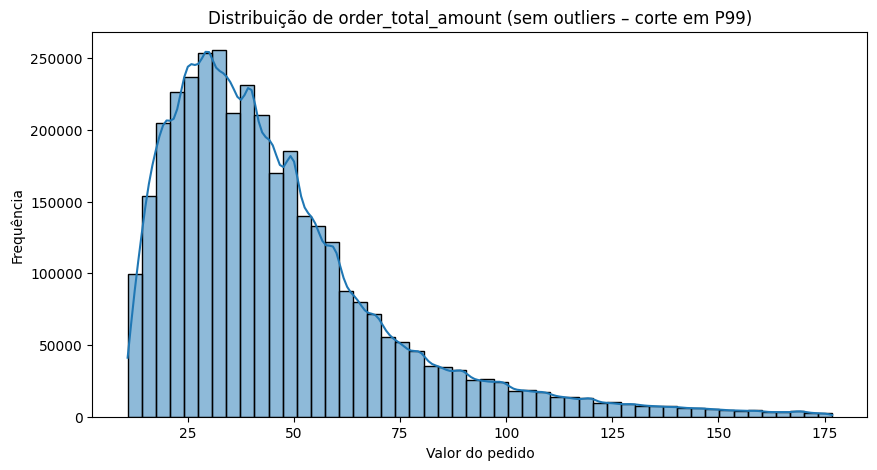

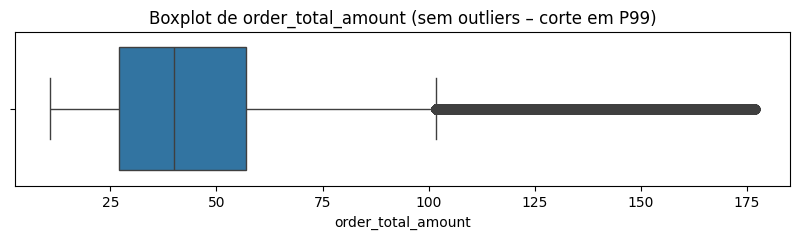

In [18]:
total_before = orders.count()
print(f"Quantidade de linhas antes do tratamento: {total_before}")

order_amount_pd = (
    orders
    .select("order_total_amount")
    .dropna()
    .toPandas()
)

p99 = order_amount_pd["order_total_amount"].quantile(0.99)
p01 = order_amount_pd["order_total_amount"].quantile(0.01)

print(f"Percentil 99 (P99): {p99}")

orders_clean = orders.filter(
    col("order_total_amount") <= p99
)

orders_clean = orders_clean.filter(
    col("order_total_amount") >= p01
)

total_after = orders_clean.count()

print(f"Quantidade de linhas após exclusão dos outliers: {total_after}")
print(
    f"Percentual removido: "
    f"{round((total_before - total_after) / total_before * 100, 2)}%"
)

print("Estatísticas descritivas (intervalo normal):")
orders_clean.select("order_total_amount").describe().show()

orders_clean.select(
    F.expr(
        "percentile_approx(order_total_amount, array(0.01, 0.25, 0.5, 0.75, 0.99))"
    ).alias("percentis")
).show(truncate=False)

print(f"Intervalo normal considerado: {round(p01, 2)} até {round(p99, 2)}")

df_plot = (
    orders_clean
    .select("order_total_amount")
    .dropna()
    .toPandas()
)

plt.figure(figsize=(10, 5))
sns.histplot(df_plot["order_total_amount"], bins=50, kde=True)
plt.title("Distribuição de order_total_amount (sem outliers – corte em P99)")
plt.xlabel("Valor do pedido")
plt.ylabel("Frequência")
plt.show()

plt.figure(figsize=(10, 2))
sns.boxplot(x=df_plot["order_total_amount"])
plt.title("Boxplot de order_total_amount (sem outliers – corte em P99)")
plt.show()

📌 Tratamento de outliers - Método 2

Para o tratamento de outliers da variável order_total_amount, foi aplicado o método do Intervalo Interquartil (IQR), que considera como valores atípicos aqueles situados abaixo de Q1 − 1.5×IQR ou acima de Q3 + 1.5×IQR.

Esse método foi escolhido por ser robusto a distribuições assimétricas e amplamente utilizado em análises exploratórias, permitindo a remoção de extremos sem depender de suposições de normalidade dos dados.

Após a aplicação do IQR, os registros fora do intervalo considerado normal foram excluídos, e as análises subsequentes foram realizadas apenas sobre a base tratada.

Quantidade de linhas antes do tratamento: 3670826
Q1: 26.899999618530273
Q3: 56.599998474121094
IQR: 29.69999885559082
Limite inferior: -17.649998664855957
Limite superior: 101.14999675750732
Quantidade de linhas após exclusão por IQR: 3448675
Percentual removido: 6.05%
Estatísticas descritivas (intervalo normal):
+-------+------------------+
|summary|order_total_amount|
+-------+------------------+
|  count|           3448675|
|   mean|41.426442735326894|
| stddev|19.985956780820846|
|    min|               0.0|
|    max|            101.14|
+-------+------------------+

Intervalo normal considerado: -17.65 até 101.15


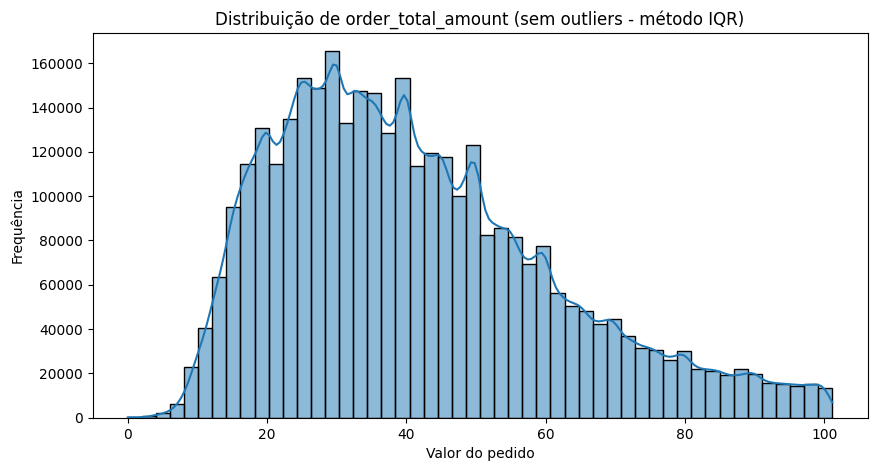

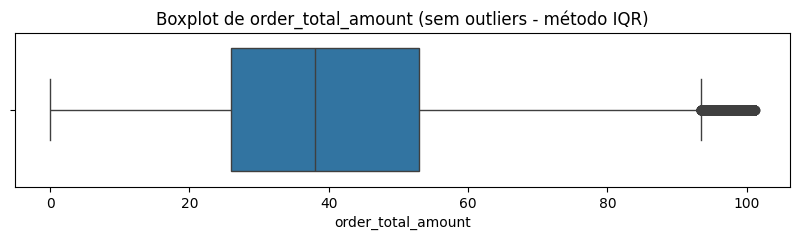

In [19]:
total_before = orders.count()
print(f"Quantidade de linhas antes do tratamento: {total_before}")

q1, q3 = orders.approxQuantile(
    "order_total_amount",
    [0.25, 0.75],
    0.01
)

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Q1: {q1}")
print(f"Q3: {q3}")
print(f"IQR: {iqr}")
print(f"Limite inferior: {lower_bound}")
print(f"Limite superior: {upper_bound}")

orders_iqr = orders.filter(
    (col("order_total_amount") >= lower_bound) &
    (col("order_total_amount") <= upper_bound)
)

total_after = orders_iqr.count()

print(f"Quantidade de linhas após exclusão por IQR: {total_after}")
print(
    f"Percentual removido: "
    f"{round((total_before - total_after) / total_before * 100, 2)}%"
)

print("Estatísticas descritivas (intervalo normal):")
orders_iqr.select("order_total_amount").describe().show()

print(
    f"Intervalo normal considerado: "
    f"{round(lower_bound, 2)} até {round(upper_bound, 2)}"
)

df_plot = (
    orders_iqr
    .select("order_total_amount")
    .dropna()
    .toPandas()
)

plt.figure(figsize=(10, 5))
sns.histplot(df_plot["order_total_amount"], bins=50, kde=True)
plt.title("Distribuição de order_total_amount (sem outliers - método IQR)")
plt.xlabel("Valor do pedido")
plt.ylabel("Frequência")
plt.show()

plt.figure(figsize=(10, 2))
sns.boxplot(x=df_plot["order_total_amount"])
plt.title("Boxplot de order_total_amount (sem outliers - método IQR)")
plt.show()

✍️ Decisão sobre o método de tratamento de outliers

Após a aplicação e avaliação de diferentes abordagens para tratamento de outliers na variável order_total_amount, foram comparados o corte por percentil (P99) e o método do Intervalo Interquartil (IQR), com base nas distribuições e boxplots gerados.

A análise visual indicou que a variável apresenta uma cauda longa à direita contínua, característica típica de dados monetários, sem evidências de rupturas abruptas ou valores espúrios que indicassem erro de registro. Esse comportamento sugere que pedidos de maior valor fazem parte do padrão natural do negócio.

Embora o método do IQR seja amplamente utilizado em análises exploratórias, sua aplicação neste contexto mostrou-se excessivamente restritiva. Observou-se que o intervalo considerado normal incluiu valores negativos, incompatíveis com a natureza da variável, além de promover um truncamento significativo da cauda direita, removendo pedidos legítimos de maior valor.

Diante disso, optou-se pelo corte por percentil (P99) como abordagem final para tratamento de outliers, por permitir a redução da influência de valores extremamente elevados sem descaracterizar a distribuição original dos dados. Essa escolha preserva a coerência semântica da variável, mantém a representatividade do comportamento observado e garante maior robustez e interpretabilidade às análises estatísticas subsequentes.

No bloco abaixo estarei apenas filtrando a base de acordo com a minha escolha.

In [20]:
total_before = orders.count()
print(f"Quantidade de linhas antes do tratamento: {total_before}")

order_amount_pd = (
    orders
    .select("order_total_amount")
    .dropna()
    .toPandas()
)

p99 = order_amount_pd["order_total_amount"].quantile(0.99)
p01 = order_amount_pd["order_total_amount"].quantile(0.01)

print(f"Percentil 99 (P99): {p99}")

orders_clean = orders.filter(
    col("order_total_amount") <= p99
)

orders_clean = orders_clean.filter(
    col("order_total_amount") >= p01
)

total_after = orders_clean.count()

print(f"Quantidade de linhas após exclusão dos outliers: {total_after}")
print(
    f"Percentual removido: "
    f"{round((total_before - total_after) / total_before * 100, 2)}%"
)

print("Estatísticas descritivas (intervalo normal):")
orders_clean.select("order_total_amount").describe().show()

orders_clean.select(
    F.expr(
        "percentile_approx(order_total_amount, array(0.01, 0.25, 0.5, 0.75, 0.99))"
    ).alias("percentis")
).show(truncate=False)

print(f"Intervalo normal considerado: {round(p01, 2)} até {round(p99, 2)}")

orders = orders_clean

Quantidade de linhas antes do tratamento: 3670826
Percentil 99 (P99): 176.8000030517578
Quantidade de linhas após exclusão dos outliers: 3597571
Percentual removido: 2.0%
Estatísticas descritivas (intervalo normal):
+-------+------------------+
|summary|order_total_amount|
+-------+------------------+
|  count|           3597571|
|   mean| 46.14409607791439|
| stddev| 27.26427703361769|
|    min|              10.8|
|    max|             176.8|
+-------+------------------+

+-------------------------------+
|percentis                      |
+-------------------------------+
|[12.2, 27.0, 39.9, 56.9, 145.2]|
+-------------------------------+

Intervalo normal considerado: 10.8 até 176.8


✍️

Para melhor compreensão da estrutura financeira associada aos pedidos, a coluna items, originalmente armazenada como um array, foi "desagrupada".

Essa transformação permitiu a inspeção detalhada dos elementos internos da estrutura, viabilizando análises exploratórias sobre composição de valores e tipos de conta associados a cada pedido.

In [21]:
money_schema = StructType([
    StructField("value", StringType(), True),
    StructField("currency", StringType(), True)
])

garnish_schema = StructType([
    StructField("name", StringType(), True),
    StructField("addition", money_schema, True),
    StructField("discount", money_schema, True),
    StructField("quantity", DoubleType(), True),
    StructField("sequence", IntegerType(), True),
    StructField("unitPrice", money_schema, True),
    StructField("categoryId", StringType(), True),
    StructField("externalId", StringType(), True),
    StructField("totalValue", money_schema, True),
    StructField("categoryName", StringType(), True),
    StructField("integrationId", StringType(), True)
])

item_schema = StructType([
    StructField("name", StringType(), True),
    StructField("addition", money_schema, True),
    StructField("discount", money_schema, True),
    StructField("quantity", DoubleType(), True),
    StructField("sequence", IntegerType(), True),
    StructField("unitPrice", money_schema, True),
    StructField("externalId", StringType(), True),
    StructField("totalValue", money_schema, True),
    StructField("customerNote", StringType(), True),
    StructField("garnishItems", ArrayType(garnish_schema), True),
    StructField("integrationId", StringType(), True),
    StructField("totalAddition", money_schema, True),
    StructField("totalDiscount", money_schema, True)
])

items_schema = ArrayType(item_schema)

orders_items_parsed = orders.withColumn(
    "items_array",
    from_json(col("items"), items_schema)
)

orders_items_parsed.printSchema()

orders_items_exploded = (
    orders_items_parsed
    .select(
        "order_id",
        explode("items_array").alias("item")
    )
)

orders_items_exploded.select(
    "order_id",
    col("item.name").alias("item_name"),
    col("item.quantity").alias("item_quantity"),
    col("item.unitPrice.value").cast("double").alias("item_unit_price"),
    col("item.totalValue.value").cast("double").alias("item_total_value"),
    col("item.totalAddition.value").cast("double").alias("item_total_addition"),
    col("item.totalDiscount.value").cast("double").alias("item_total_discount")
).show(10, truncate=False)

root
 |-- cpf: string (nullable = true)
 |-- customer_id: string (nullable = true)
 |-- customer_name: string (nullable = true)
 |-- delivery_address_city: string (nullable = true)
 |-- delivery_address_country: string (nullable = true)
 |-- delivery_address_district: string (nullable = true)
 |-- delivery_address_external_id: string (nullable = true)
 |-- delivery_address_latitude: float (nullable = true)
 |-- delivery_address_longitude: float (nullable = true)
 |-- delivery_address_state: string (nullable = true)
 |-- delivery_address_zip_code: string (nullable = true)
 |-- items: string (nullable = true)
 |-- merchant_id: string (nullable = true)
 |-- merchant_latitude: float (nullable = true)
 |-- merchant_longitude: float (nullable = true)
 |-- merchant_timezone: string (nullable = true)
 |-- order_created_at: timestamp (nullable = true)
 |-- order_id: string (nullable = true)
 |-- order_scheduled: boolean (nullable = true)
 |-- order_scheduled_date: timestamp (nullable = true)
 |

📊 Análise estatística de item_total_discount

+-------+-----------------------+
|summary|item_total_discount_brl|
+-------+-----------------------+
|  count|                7244378|
|   mean|                    0.0|
| stddev|                    0.0|
|    min|                    0.0|
|    max|                    0.0|
+-------+-----------------------+

+-------------------------+
|percentis                |
+-------------------------+
|[0.0, 0.0, 0.0, 0.0, 0.0]|
+-------------------------+



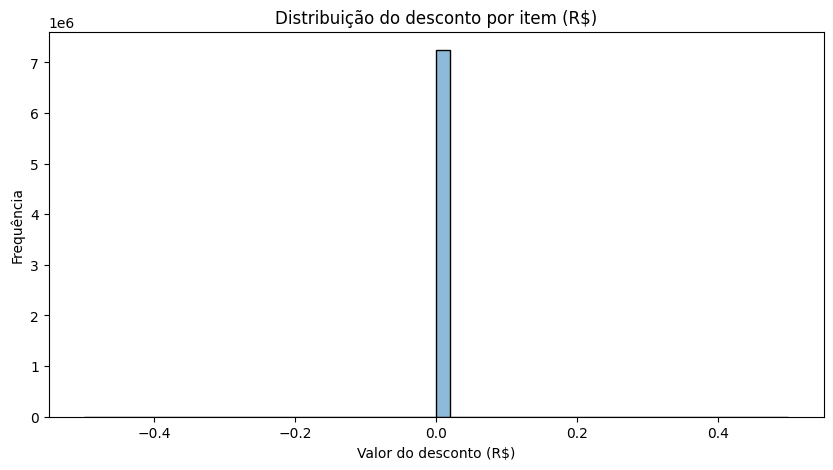

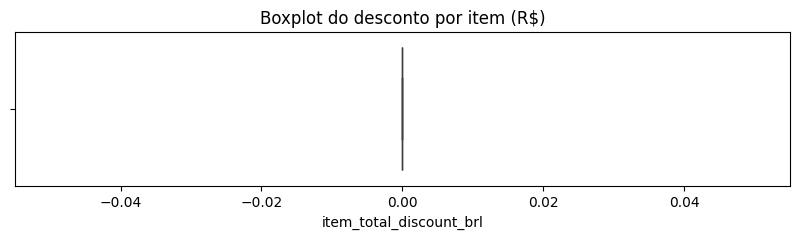

In [22]:
items_discount = orders_items_exploded.withColumn(
    "item_total_discount_brl",
    col("item.totalDiscount.value").cast("double") / 100
)

items_discount.select("item_total_discount_brl").describe().show()

items_discount.select(
    F.expr(
        "percentile_approx(item_total_discount_brl, array(0.25, 0.5, 0.75, 0.9, 0.99))"
    ).alias("percentis")
).show(truncate=False)

df_plot_discount = (
    items_discount
    .select("item_total_discount_brl")
    .dropna()
    .toPandas()
)

plt.figure(figsize=(10, 5))
sns.histplot(df_plot_discount["item_total_discount_brl"], bins=50, kde=True)
plt.title("Distribuição do desconto por item (R$)")
plt.xlabel("Valor do desconto (R$)")
plt.ylabel("Frequência")
plt.show()

plt.figure(figsize=(10, 2))
sns.boxplot(x=df_plot_discount["item_total_discount_brl"])
plt.title("Boxplot do desconto por item (R$)")
plt.show()

✍️

Durante a análise exploratória no nível de item, foi identificado que a coluna de descontos (item_total_discount) encontrava-se integralmente zerada, não permitindo avaliar o impacto de incentivos promocionais a partir dos dados originais.

Diante disso, foi definida uma proposta de política de desconto simulada, com o objetivo de viabilizar análises exploratórias e cenários de impacto financeiro. A regra adotada considera um desconto equivalente a 10% do valor de cada item, limitado ao teto de R$ 10,00, aplicada de forma uniforme a todos os pedidos.

Para operacionalizar essa proposta, os dados foram agregados no nível do pedido, calculando-se o valor bruto como a soma dos valores dos itens, o desconto como a soma dos descontos propostos por item, e o valor final como a diferença entre o valor bruto e o desconto aplicado.

Essa abordagem permite simular o efeito de uma política de descontos de forma controlada e consistente, mantendo clareza metodológica e separando explicitamente dados reais de cenários hipotéticos utilizados para análise.

In [23]:
items_with_discount = orders.withColumn(
    "desconto",
    least(
        col("order_total_amount") * 0.10,
        col("order_total_amount") * 0 + 10
    )
)

orders_with_discount = items_with_discount.withColumn(
    "valor_final",
    col("order_total_amount") - col("desconto")
)

orders_with_discount.show(10, truncate=False)

+-----------+----------------------------------------------------------------+-------------+---------------------+------------------------+-------------------------+----------------------------+-------------------------+--------------------------+----------------------+-------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
orders_with_discount.select("desconto").describe().show()

orders_with_discount.select(
    F.expr(
        "percentile_approx(desconto, array(0.25, 0.5, 0.75, 0.9, 0.99))"
    ).alias("percentis")
).show(truncate=False)

df_plot_discount = (
    orders_with_discount
    .select("desconto")
    .dropna()
    .toPandas()
)

+-------+------------------+
|summary|          desconto|
+-------+------------------+
|  count|           3597571|
|   mean| 4.477584067160723|
| stddev| 2.318739441558387|
|    min|1.0800000190734864|
|    max|              10.0|
+-------+------------------+

+-------------------------------------------------------------------+
|percentis                                                          |
+-------------------------------------------------------------------+
|[2.7, 3.990000152587891, 5.690000152587891, 8.10999984741211, 10.0]|
+-------------------------------------------------------------------+



✍️ Validação da política de desconto proposta

Após a aplicação da política de desconto simulada, foi realizada uma análise estatística descritiva da coluna desconto com o objetivo exclusivo de validar o correto funcionamento da regra definida.

Essa etapa teve como finalidade confirmar que o desconto aplicado respeita o limite máximo de R$ 10,00 por pedido, conforme especificado na política proposta, e que não existem valores acima desse teto decorrentes do cálculo ou da agregação.

📌 Construção da base analítica com marcação do Teste A/B

In [24]:
orders_ab = (
    orders_with_discount
    .join(
        ab_test.select("customer_id", "is_target"),
        on="customer_id",
        how="inner"
    )
)

orders_ab.show(5, truncate=False)

print('Quantidade de Resgistros:')
print("Tabela Final:", orders_ab.count())

+----------------------------------------------------------------+-----------+-------------+---------------------+------------------------+-------------------------+----------------------------+-------------------------+--------------------------+----------------------+-------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [25]:
window_user = Window.partitionBy("customer_id").orderBy("order_created_at")

df_aux = (
    orders_ab
    .withColumn("primeiro_pedido", min("order_created_at").over(window_user))
    .withColumn("ultimo_pedido", max("order_created_at").over(window_user))
    .withColumn(
        "dias_desde_ultimo_pedido",
        datediff(F.current_date(), col("ultimo_pedido"))
    )
    .withColumn(
        "tempo_vida",
        datediff(col("ultimo_pedido"), col("primeiro_pedido"))
    )
    .withColumn(
        "estado_cliente",
        first("delivery_address_state").over(window_user)
    )
    .withColumn(
        "plataforma_cliente",
        first("origin_platform").over(window_user)
    )
)

tabela_final = (
    df_aux
    .groupBy("customer_id", "is_target")
    .agg(
        count("order_id").alias("qtd_pedidos"),
        spark_sum("valor_final").alias("valor_total_gasto"),
        avg("valor_final").alias("ticket_medio"),

        spark_round(
            count("order_id") /
            (datediff(max("order_created_at"), min("order_created_at")) / 30 + 1),
            2
        ).alias("frequencia_mensal"),

        max("dias_desde_ultimo_pedido").alias("dias_desde_ultimo_pedido"),
        countDistinct("merchant_id").alias("qtd_restaurantes_diferentes"),
        max("tempo_vida").alias("tempo_vida"),
        first("estado_cliente").alias("estado"),
        first("plataforma_cliente").alias("plataforma")
    )
)

In [26]:
tabela_final.show(5, truncate=False)

+----------------------------------------------------------------+---------+-----------+------------------+-----------------+-----------------+------------------------+---------------------------+----------+------+----------+
|customer_id                                                     |is_target|qtd_pedidos|valor_total_gasto |ticket_medio     |frequencia_mensal|dias_desde_ultimo_pedido|qtd_restaurantes_diferentes|tempo_vida|estado|plataforma|
+----------------------------------------------------------------+---------+-----------+------------------+-----------------+-----------------+------------------------+---------------------------+----------+------+----------+
|00021cd56b6d6c980c3b48ca0fdf8c53cf3fea776d74ab401d02b84a5bc1bbad|target   |5          |71.72999897003174 |14.34599979400635|2.0              |2569                    |3                          |45        |SP    |ANDROID   |
|00029b26fb2121119b6d07a275088befd3535f26f38787d5f03995dafd7c4c55|target   |1          |49.13999

In [27]:
numericas = [
    "qtd_pedidos",
    "valor_total_gasto",
    "ticket_medio",
    "frequencia_mensal",
    "dias_desde_ultimo_pedido",
    "qtd_restaurantes_diferentes",
    "tempo_vida"
]

aggs = []
for col_name in numericas:
    aggs.append(mean(col_name).alias(f"{col_name}_media"))
    aggs.append(
        percentile_approx(col_name, 0.5, 100)
        .alias(f"{col_name}_mediana")
    )

df_estatisticas_ab = (
    tabela_final
    .groupBy("is_target")
    .agg(*aggs)
)

df_estatisticas_ab.show(truncate=False)

+---------+------------------+-------------------+-----------------------+-------------------------+------------------+--------------------+-----------------------+-------------------------+------------------------------+--------------------------------+---------------------------------+-----------------------------------+------------------+------------------+
|is_target|qtd_pedidos_media |qtd_pedidos_mediana|valor_total_gasto_media|valor_total_gasto_mediana|ticket_medio_media|ticket_medio_mediana|frequencia_mensal_media|frequencia_mensal_mediana|dias_desde_ultimo_pedido_media|dias_desde_ultimo_pedido_mediana|qtd_restaurantes_diferentes_media|qtd_restaurantes_diferentes_mediana|tempo_vida_media  |tempo_vida_mediana|
+---------+------------------+-------------------+-----------------------+-------------------------+------------------+--------------------+-----------------------+-------------------------+------------------------------+--------------------------------+--------------------

✍️

Nesta etapa foi realizada a construção da base analítica final, com foco em garantir consistência de granularidade, aderência ao desenho experimental do teste A/B e robustez das métricas numéricas utilizadas nas análises subsequentes.

Inicialmente, os dados de pedidos foram integrados à marcação do experimento A/B, assegurando que cada pedido estivesse corretamente associado ao grupo experimental correspondente (is_target). Essa integração permitiu que apenas clientes participantes do experimento fossem considerados nas análises.

Em seguida, foi aplicada uma política de desconto simulada, motivada pela identificação de que os campos de desconto originais encontravam-se zerados. A política proposta considera um desconto equivalente a 10% do valor do pedido, limitado ao teto de R$ 10,00, aplicada de forma uniforme. A coluna valor_final foi então criada no nível do pedido como a diferença entre o valor original e o desconto aplicado, garantindo uma métrica financeira consistente para análise.

Após a criação das métricas financeiras, os dados foram enriquecidos com informações temporais e comportamentais no nível do cliente, utilizando funções de janela para identificar o primeiro e o último pedido, calcular o tempo de relacionamento, a recência de compra e capturar atributos estáveis, como estado e plataforma de origem.

Com essas informações disponíveis, os dados foram agregados no nível do cliente (customer_id), respeitando a unidade experimental do teste A/B. Foram calculadas métricas como quantidade de pedidos, valor total gasto, ticket médio, frequência mensal de pedidos, diversidade de restaurantes, tempo de vida do cliente e recência, formando uma base consolidada e adequada para análises comparativas entre os grupos.

Por fim, foi realizada uma análise exploratória das métricas numéricas da base final, comparando média e mediana por grupo experimental. Essa etapa teve como objetivo avaliar assimetrias e a influência de valores extremos, fornecendo subsídios para a correta interpretação dos resultados e para a escolha de métricas e testes estatísticos apropriados nas etapas seguintes da análise do teste A/B.

# **Etapa 3:** Teste A/B

📌 Descrição da etapa

Nesta etapa foi realizada a análise do teste A/B da campanha de cupons, cujo objetivo é avaliar o impacto da ação promocional sobre métricas-chave de comportamento e resultado financeiro dos usuários. A base utilizada contém a marcação dos clientes em grupo controle e grupo teste, permitindo a validação de hipóteses de crescimento em um ambiente controlado.

Métricas escolhidas:

- Retenção (control × target)
- Frequência de pedidos (control × target)
- Ticket médio (control × target)
- Recência (control × target)
- Valor total gasto por cliente (control × target)

🔹 Cálculo de Retenção

In [29]:
df_pedidos_por_usuario = (
    orders_ab
    .groupBy("customer_id", "is_target")
    .agg(F.count("order_id").alias("qtd_pedidos"))
)

df_pedidos_por_usuario = df_pedidos_por_usuario.withColumn(
    "retido",
    F.col("qtd_pedidos") > 1
)

df_retencao = (
    df_pedidos_por_usuario
    .groupBy("is_target")
    .agg(
        F.sum(F.col("retido").cast("int")).alias("usuarios_retidos"),
        F.count("customer_id").alias("total_usuarios")
    )
    .withColumn(
        "taxa_retencao",
        F.col("usuarios_retidos") / F.col("total_usuarios")
    )
)

df_retencao.show()

dados = df_retencao.collect()

info = {
    str(l["is_target"]).lower(): {
        "retidos": int(l["usuarios_retidos"]),
        "total": int(l["total_usuarios"]),
        "taxa": float(l["taxa_retencao"])
    }
    for l in dados
}

if "target" in info and "control" in info:
    taxa_target = info["target"]["taxa"]
    taxa_control = info["control"]["taxa"]

    variacao = ((taxa_target - taxa_control) / taxa_control) * 100

    count = [
        info["target"]["retidos"],
        info["control"]["retidos"]
    ]
    nobs = [
        info["target"]["total"],
        info["control"]["total"]
    ]

    z_stat, p_value = proportions_ztest(count, nobs)

    print(
        f"A taxa de retenção do grupo target foi {taxa_target:.2%}, "
        f"enquanto a do grupo controle foi {taxa_control:.2%}. "
        f"Variação relativa de {variacao:.2f}%."
    )

    print(f"Teste de proporções (z-test): z = {z_stat:.3f}, p-value = {p_value:.4f}")

    if p_value < 0.05:
        print("✅ Diferença estatisticamente significativa (nível de 5%).")
    else:
        print("⚠️ Diferença NÃO estatisticamente significativa (nível de 5%).")

+---------+----------------+--------------+------------------+
|is_target|usuarios_retidos|total_usuarios|     taxa_retencao|
+---------+----------------+--------------+------------------+
|  control|          266068|        356506|0.7463212400352308|
|   target|          350372|        441646|0.7933322162999326|
+---------+----------------+--------------+------------------+

A taxa de retenção do grupo target foi 79.33%, enquanto a do grupo controle foi 74.63%. Variação relativa de 6.30%.
Teste de proporções (z-test): z = 49.794, p-value = 0.0000
✅ Diferença estatisticamente significativa (nível de 5%).


🔹 Cálculo da Frequência

In [30]:
df_frequencia = (
    tabela_final
    .groupBy("is_target")
    .agg(F.avg("frequencia_mensal").alias("frequencia_media"))
)

df_frequencia.show()

dados = df_frequencia.collect()
freq_media = {str(l["is_target"]).lower(): float(l["frequencia_media"]) for l in dados}

if "target" in freq_media and "control" in freq_media:

    variacao = ((freq_media["target"] - freq_media["control"]) / freq_media["control"]) * 100

    print(
        f"A frequência média mensal no grupo target foi {freq_media['target']:.2f}, "
        f"contra {freq_media['control']:.2f} no controle "
        f"(variação de {variacao:.2f}%)."
    )

freq_target = (
    tabela_final
    .filter(F.col("is_target") == "target")
    .select("frequencia_mensal")
    .dropna()
    .toPandas()["frequencia_mensal"]
)

freq_control = (
    tabela_final
    .filter(F.col("is_target") == "control")
    .select("frequencia_mensal")
    .dropna()
    .toPandas()["frequencia_mensal"]
)

u_stat, p_value = mannwhitneyu(freq_target, freq_control, alternative="two-sided")

print(f"Teste p-value = {p_value:.4f}")

if p_value < 0.05:
    print("✅ Diferença estatisticamente significativa (nível de 5%).")
else:
    print("⚠️ Diferença NÃO estatisticamente significativa (nível de 5%).")

+---------+-----------------+
|is_target| frequencia_media|
+---------+-----------------+
|  control|1.933367292556074|
|   target|2.122983792449102|
+---------+-----------------+

A frequência média mensal no grupo target foi 2.12, contra 1.93 no controle (variação de 9.81%).
Teste p-value = 0.0000
✅ Diferença estatisticamente significativa (nível de 5%).


🔹 Cálculo do Ticket Médio

In [31]:
df_ticket = (
    tabela_final
    .groupBy("is_target")
    .agg(F.avg("ticket_medio").alias("ticket_medio"))
)

df_ticket.show()

dados = df_ticket.collect()
ticket_media = {str(l["is_target"]).lower(): float(l["ticket_medio"]) for l in dados}

if "target" in ticket_media and "control" in ticket_media:

    variacao = ((ticket_media["target"] - ticket_media["control"]) / ticket_media["control"]) * 100

    print(
        f"O ticket médio do grupo target foi R$ {ticket_media['target']:.2f}, "
        f"enquanto no controle foi R$ {ticket_media['control']:.2f} "
        f"(variação de {variacao:.2f}%)."
    )

ticket_target = (
    tabela_final
    .filter(F.col("is_target") == "target")
    .select("ticket_medio")
    .dropna()
    .toPandas()["ticket_medio"]
)

ticket_control = (
    tabela_final
    .filter(F.col("is_target") == "control")
    .select("ticket_medio")
    .dropna()
    .toPandas()["ticket_medio"]
)

t_stat, p_value = ttest_ind(ticket_target, ticket_control, equal_var=False)

print(f"Teste p-value = {p_value:.4f}")

if p_value < 0.05:
    print("✅ Diferença estatisticamente significativa (nível de 5%).")
else:
    print("⚠️ Diferença NÃO estatisticamente significativa (nível de 5%).")

+---------+-----------------+
|is_target|     ticket_medio|
+---------+-----------------+
|  control|41.77699659879787|
|   target|41.79212412230017|
+---------+-----------------+

O ticket médio do grupo target foi R$ 41.79, enquanto no controle foi R$ 41.78 (variação de 0.04%).
Teste p-value = 0.7636
⚠️ Diferença NÃO estatisticamente significativa (nível de 5%).


🔹 Cálculo de Recência

In [32]:
df_diff = (
    orders_ab
    .withColumn("pedido_anterior", F.lag("order_created_at").over(window_user))
    .withColumn(
        "dias_entre_pedidos",
        F.datediff("order_created_at", "pedido_anterior")
    )
    .filter(F.col("pedido_anterior").isNotNull())
)

df_recencia_usuario = (
    df_diff
    .groupBy("customer_id", "is_target")
    .agg(
        F.expr(
            "percentile_approx(dias_entre_pedidos, 0.5)"
        ).alias("recencia_mediana")
    )
)

df_recencia_grupo = (
    df_recencia_usuario
    .groupBy("is_target")
    .agg(
        F.expr(
            "percentile_approx(recencia_mediana, 0.5)"
        ).alias("recencia_mediana_grupo")
    )
)

df_recencia_grupo.show()

dados = df_recencia_grupo.collect()
rec = {str(l["is_target"]).lower(): float(l["recencia_mediana_grupo"]) for l in dados}

if "target" in rec and "control" in rec:

    diferenca_dias = rec["control"] - rec["target"]
    variacao = (diferenca_dias / rec["control"]) * 100

    print(
        f"A mediana do tempo entre pedidos no grupo target foi {rec['target']:.1f} dias, "
        f"contra {rec['control']:.1f} dias no controle, "
        f"representando redução de {diferenca_dias:.1f} dias "
        f"({variacao:.2f}%)."
    )

rec_target = (
    df_recencia_usuario
    .filter(F.col("is_target") == "target")
    .select("recencia_mediana")
    .dropna()
    .toPandas()["recencia_mediana"]
)

rec_control = (
    df_recencia_usuario
    .filter(F.col("is_target") == "control")
    .select("recencia_mediana")
    .dropna()
    .toPandas()["recencia_mediana"]
)

u_stat, p_value = mannwhitneyu(rec_target, rec_control, alternative="two-sided")

print(f"Teste p-value = {p_value:.4f}")

if p_value < 0.05:
    print("✅ Diferença estatisticamente significativa (nível de 5%).")
else:
    print("⚠️ Diferença NÃO estatisticamente significativa (nível de 5%).")

+---------+----------------------+
|is_target|recencia_mediana_grupo|
+---------+----------------------+
|  control|                     9|
|   target|                     7|
+---------+----------------------+

A mediana do tempo entre pedidos no grupo target foi 7.0 dias, contra 9.0 dias no controle, representando redução de 2.0 dias (22.22%).
Teste p-value = 0.0000
✅ Diferença estatisticamente significativa (nível de 5%).


🔹 Cálculo do Valor Total

In [33]:
df_valor_total = (
    tabela_final
    .groupBy("is_target")
    .agg(F.avg("valor_total_gasto").alias("valor_medio"))
)

df_valor_total.show()

dados = df_valor_total.collect()
valor_medio = {str(l["is_target"]).lower(): float(l["valor_medio"]) for l in dados}

if "target" in valor_medio and "control" in valor_medio:

    variacao = ((valor_medio["target"] - valor_medio["control"]) / valor_medio["control"]) * 100

    print(
        f"O valor médio gasto por cliente no grupo target foi R$ {valor_medio['target']:.2f}, "
        f"contra R$ {valor_medio['control']:.2f} no controle "
        f"(uplift de {variacao:.2f}%)."
    )

valor_target = (
    tabela_final
    .filter(F.col("is_target") == "target")
    .select("valor_total_gasto")
    .dropna()
    .toPandas()["valor_total_gasto"]
)

valor_control = (
    tabela_final
    .filter(F.col("is_target") == "control")
    .select("valor_total_gasto")
    .dropna()
    .toPandas()["valor_total_gasto"]
)

u_stat, p_value = mannwhitneyu(valor_target, valor_control, alternative="two-sided")

print(f"Teste p-value = {p_value:.4f}")

if p_value < 0.05:
    print("✅ Diferença estatisticamente significativa (nível de 5%).")
else:
    print("⚠️ Diferença NÃO estatisticamente significativa (nível de 5%).")

+---------+------------------+
|is_target|       valor_medio|
+---------+------------------+
|  control|174.76393921162682|
|   target|197.42815813700128|
+---------+------------------+

O valor médio gasto por cliente no grupo target foi R$ 197.43, contra R$ 174.76 no controle (uplift de 12.97%).
Teste p-value = 0.0000
✅ Diferença estatisticamente significativa (nível de 5%).


✍️

A campanha de cupons apresentou impacto positivo e estatisticamente significativo nas principais métricas de engajamento e monetização. Observou-se aumento da retenção, da frequência de pedidos, redução do tempo entre compras e crescimento do valor total gasto por cliente. O ticket médio permaneceu estável, indicando que o crescimento observado foi impulsionado pelo aumento do número de pedidos e não por distorções no valor das compras. Esses resultados sugerem que a campanha foi eficaz em estimular recorrência e gerar crescimento sustentável no período analisado.

O comportamento observado indica que:

- ✅ O cupom não fez o usuário gastar mais por pedido

- ✅ O cupom fez o usuário:

>> voltar mais

>> comprar mais vezes

>> omprar mais rápido

# **Etapa 4:** Análise de Viabilidade Financeira da Campanha

📌 Descrição da etapa

Nesta etapa foi realizada a análise de viabilidade financeira da campanha de cupons, com o objetivo de avaliar se o impacto positivo observado nas métricas comportamentais e de consumo compensa o custo associado à concessão dos descontos.

Premissas:
- Vou considerar o custo do cupom em R$ 10,00 por usuário, assumindo que o iFood financiou 100% do incentivo;
- O objetivo principal da campanha não é lucro imediato, mas sim aumentar retenção e o valor de vida do cliente (LTV) no médio e longo prazo;
- A margem de contribuição da empresa é de 25% sobre a receita gerada;
- O ticket médio é considerado estável, já que não apresentou diferença estatisticamente significativa entre os grupos;

In [39]:
def to_float(x):
    if hasattr(x, "iloc"):
        return float(x.iloc[0])
    return float(x)

retencao_target = retidos_target / total_target
retencao_control = retidos_control / total_control

ret_target = retencao_target
ret_control = retencao_control
delta_retencao = ret_target - ret_control

usuarios_target = int(total_target)

freq_target_media = frequencia_target
freq_control_media = frequencia_control

ticket_target_val = ticket_target.mean()
ticket_control_val = ticket_control.mean()

ticket_medio = (ticket_target_val + ticket_control_val) / 2

margem_contribuicao = 0.25
custo_cupom_max = 10.00
custo_total_campanha = usuarios_target * custo_cupom_max

pedidos_esperados_sem_cupom = usuarios_target * freq_control_media
pedidos_observados_com_cupom = usuarios_target * freq_target_media

pedidos_incrementais = pedidos_observados_com_cupom - pedidos_esperados_sem_cupom

receita_incremental_bruta = pedidos_incrementais * ticket_medio
lucro_incremental = receita_incremental_bruta * margem_contribuicao

resultado_liquido = lucro_incremental - custo_total_campanha
roi = resultado_liquido / custo_total_campanha if custo_total_campanha > 0 else 0

ltv_control = (
    ret_control *
    freq_control_media *
    ticket_control_val *
    margem_contribuicao
)

ltv_target = (
    ret_target *
    freq_target_media *
    ticket_target_val *
    margem_contribuicao
)

incremento_ltv = float(ltv_target - ltv_control)

receita_futura_incr_por_usuario = incremento_ltv

payback_meses = (
    custo_cupom_max / receita_futura_incr_por_usuario
    if receita_futura_incr_por_usuario > 0
    else float("inf")
)


In [40]:
print("📊 Análise de Viabilidade Financeira da Campanha\n")

print(f"Usuários impactados (grupo target): {usuarios_target:,}")
print(f"Retenção — Target: {retencao_target:.2%} | Controle: {retencao_control:.2%}\n")

print(f"Pedidos incrementais estimados: {pedidos_incrementais:,.0f}")
print(f"Ticket médio considerado: R$ {ticket_medio:,.2f}\n")

print(f"Receita incremental bruta: R$ {receita_incremental_bruta:,.2f}")
print(f"Lucro incremental (margem {margem_contribuicao:.0%}): R$ {lucro_incremental:,.2f}\n")

print(f"Custo total estimado da campanha: R$ {custo_total_campanha:,.2f}")
print(f"Resultado líquido estimado: R$ {resultado_liquido:,.2f}")
print(f"ROI estimado: {roi:.2%}\n")

if roi > 0:
    print("✅ Conclusão: a campanha é financeiramente viável no cenário analisado.")
else:
    print("⚠️ Conclusão: a campanha não se mostrou financeiramente viável no cenário analisado.")

📊 Análise de Viabilidade Financeira da Campanha

Usuários impactados (grupo target): 441,646
Retenção — Target: 79.33% | Controle: 74.63%

Pedidos incrementais estimados: 83,743
Ticket médio considerado: R$ 41.78

Receita incremental bruta: R$ 3,499,179.84
Lucro incremental (margem 25%): R$ 874,794.96

Custo total estimado da campanha: R$ 4,416,460.00
Resultado líquido estimado: R$ -3,541,665.04
ROI estimado: -80.19%

⚠️ Conclusão: a campanha não se mostrou financeiramente viável no cenário analisado.


In [41]:
print("\n📈 Análise de LTV e Retenção\n")

print(f"LTV estimado por usuário — Controle: R$ {ltv_control:,.2f}")
print(f"LTV estimado por usuário — Target:   R$ {ltv_target:,.2f}")
print(f"Incremento de LTV por usuário:       R$ {incremento_ltv:,.2f}\n")

if incremento_ltv > 0:
    print(
        "✅ A campanha aumentou o valor futuro esperado por usuário, "
        "indicando impacto positivo em retenção e recorrência."
    )

    if payback_meses != float("inf"):
        print(
            f"O custo do cupom (R$ {custo_cupom_max:.2f}) pode ser recuperado "
            f"em aproximadamente {payback_meses:.1f} meses via LTV incremental."
        )
    else:
        print(
            "Apesar do aumento de LTV, o valor incremental mensal ainda não é "
            "suficiente para recuperar o investimento no horizonte analisado."
        )
else:
    print(
        "⚠️ A campanha não apresentou aumento de LTV médio por usuário "
        "em relação ao grupo controle."
    )


📈 Análise de LTV e Retenção

LTV estimado por usuário — Controle: R$ 15.07
LTV estimado por usuário — Target:   R$ 17.60
Incremento de LTV por usuário:       R$ 2.53

✅ A campanha aumentou o valor futuro esperado por usuário, indicando impacto positivo em retenção e recorrência.
O custo do cupom (R$ 10.00) pode ser recuperado em aproximadamente 4.0 meses via LTV incremental.


# **Etapa 5:** Segmentação de Clientes

🎯 Objetivo da segmentação

Criar grupos homogêneos de usuários para entender onde a campanha de cupons foi mais (ou menos) eficaz, permitindo:
- leitura mais precisa do impacto do teste A/B;
- direcionamento melhor de futuras campanhas;
- otimização de investimento.

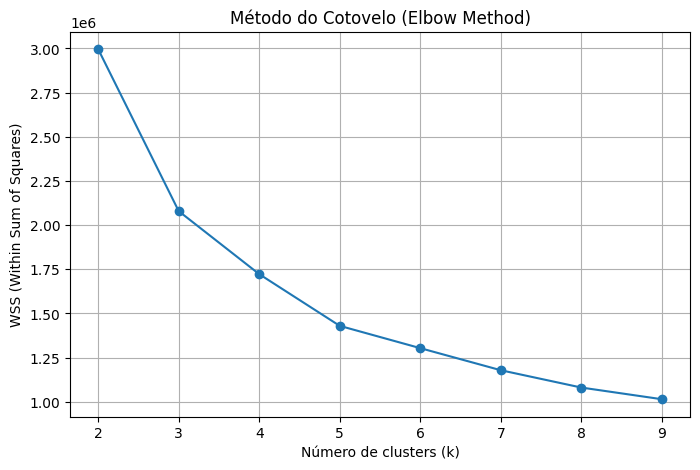

In [49]:
df_kmeans_pd = (
    tabela_final
    .select(
        "customer_id",
        "qtd_pedidos",
        "ticket_medio",
        "frequencia_mensal",
        "dias_desde_ultimo_pedido",
        "valor_total_gasto",
        "qtd_restaurantes_diferentes",
        "tempo_vida"
    )
    .toPandas()
)

df_kmeans_pd.dropna(inplace=True)

colunas_numericas = [
    "qtd_pedidos",
    "ticket_medio",
    "frequencia_mensal",
    "dias_desde_ultimo_pedido",
    "valor_total_gasto",
    "qtd_restaurantes_diferentes",
    "tempo_vida"
]

for col in colunas_numericas:
    p01 = df_kmeans_pd[col].quantile(0.01)
    p99 = df_kmeans_pd[col].quantile(0.99)
    df_kmeans_pd = df_kmeans_pd[df_kmeans_pd[col].between(p01, p99)]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_kmeans_pd[colunas_numericas])

wss = []
ks = range(2, 10)

for k in ks:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )
    kmeans.fit(X_scaled)
    wss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(ks, wss, marker="o")
plt.title("Método do Cotovelo (Elbow Method)")
plt.xlabel("Número de clusters (k)")
plt.ylabel("WSS (Within Sum of Squares)")
plt.grid(True)
plt.show()

📊 Calculando o Índice de Calinski-Harabasz para cada valor de K:

K = 2: Índice de Calinski-Harabasz = 543933.48
K = 3: Índice de Calinski-Harabasz = 555358.41
K = 4: Índice de Calinski-Harabasz = 498078.46
K = 5: Índice de Calinski-Harabasz = 487978.45
K = 6: Índice de Calinski-Harabasz = 442515.87
K = 7: Índice de Calinski-Harabasz = 420968.83
K = 8: Índice de Calinski-Harabasz = 403159.03
K = 9: Índice de Calinski-Harabasz = 381774.22


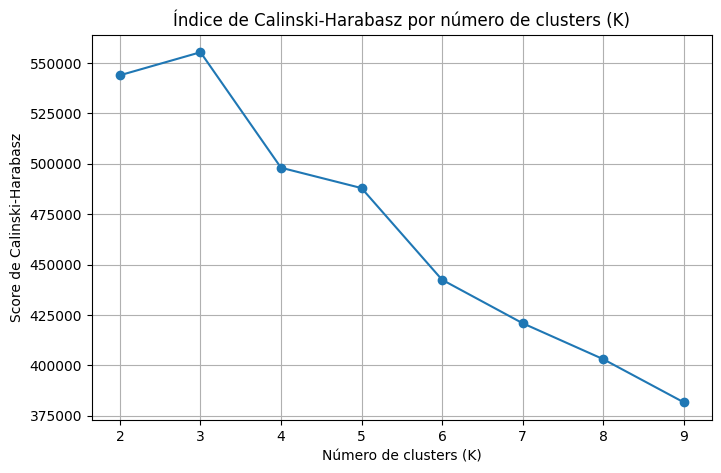

In [50]:
K_range = range(2, 10)
ch_scores = []

print("📊 Calculando o Índice de Calinski-Harabasz para cada valor de K:\n")

for k in K_range:
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10
    )

    cluster_labels = kmeans.fit_predict(X_scaled)
    score = calinski_harabasz_score(X_scaled, cluster_labels)
    ch_scores.append(score)

    print(f"K = {k}: Índice de Calinski-Harabasz = {score:.2f}")

# Plot do resultado
plt.figure(figsize=(8, 5))
plt.plot(K_range, ch_scores, marker="o")
plt.title("Índice de Calinski-Harabasz por número de clusters (K)")
plt.xlabel("Número de clusters (K)")
plt.ylabel("Score de Calinski-Harabasz")
plt.grid(True)
plt.show()

📊 Resumo médio dos clusters:



,qtd_pedidos,ticket_medio,frequencia_mensal,valor_total_gasto,qtd_restaurantes_diferentes,tempo_vida
cluster,,,,,,
0,1.32,41.40,1.21,54.10,1.22,1.94
1,3.20,40.14,1.47,125.82,1.56,34.23
2,10.10,43.62,3.94,418.29,4.24,46.67


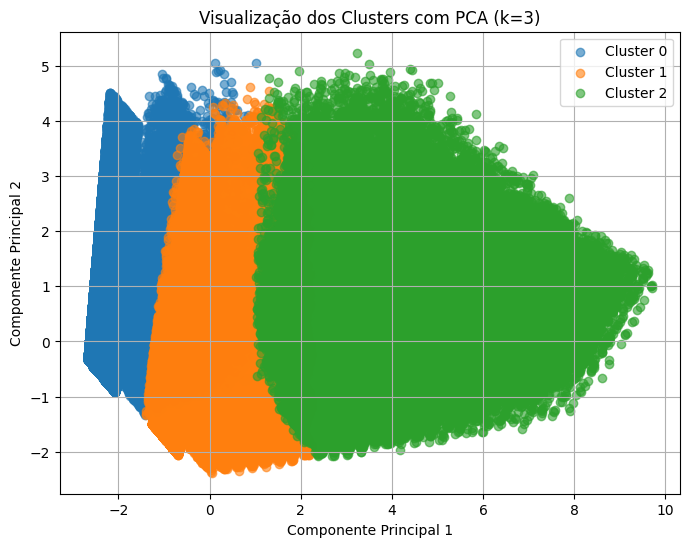

In [51]:
k = 3 # (maior valor)

kmeans = KMeans(
    n_clusters=k,
    random_state=42,
    n_init=10
)

cluster_labels = kmeans.fit_predict(X_scaled)

df_kmeans_pd["cluster"] = cluster_labels

cluster_summary = (
    df_kmeans_pd
    .groupby("cluster")
    .agg({
        "qtd_pedidos": "mean",
        "ticket_medio": "mean",
        "frequencia_mensal": "mean",
        "valor_total_gasto": "mean",
        "qtd_restaurantes_diferentes": "mean",
        "tempo_vida": "mean"
    })
    .round(2)
)

print("📊 Resumo médio dos clusters:\n")
display(cluster_summary)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
for i in range(k):
    plt.scatter(
        X_pca[cluster_labels == i, 0],
        X_pca[cluster_labels == i, 1],
        label=f"Cluster {i}",
        alpha=0.6
    )

plt.title("Visualização dos Clusters com PCA (k=3)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.legend()
plt.grid(True)
plt.show()

In [52]:
cluster_map = (
    df_kmeans_pd
    .groupby("cluster", as_index=False)["valor_total_gasto"]
    .mean()
    .sort_values("valor_total_gasto", ascending=False)
    .reset_index(drop=True)
)

rename_dict = {
    row["cluster"]: idx
    for idx, row in cluster_map.iterrows()
}

df_kmeans_pd["cluster_ordenado"] = df_kmeans_pd["cluster"].map(rename_dict)

nomes_clusters = {
    0: "Alto Engajamento",
    1: "Engajamento Moderado",
    2: "Baixo Engajamento"
}

df_kmeans_pd["cluster_nome"] = df_kmeans_pd["cluster_ordenado"].map(nomes_clusters)

df_ab_pd = (
    tabela_final
    .select("customer_id", "is_target")
    .dropDuplicates()
    .toPandas()
)

df_analise = df_kmeans_pd.merge(
    df_ab_pd,
    on="customer_id",
    how="inner"
)

agrupamento = (
    df_analise
    .groupby(["cluster_nome", "is_target"])
    .agg(
        qtd_pedidos_media=("qtd_pedidos", "mean"),
        ticket_medio_medio=("ticket_medio", "mean"),
        valor_total_gasto_medio=("valor_total_gasto", "mean"),
        frequencia_mensal_media=("frequencia_mensal", "mean"),
        qtd_restaurantes_media=("qtd_restaurantes_diferentes", "mean"),
        tempo_vida_medio=("tempo_vida", "mean"),
        num_usuarios=("customer_id", "count")
    )
    .round(2)
    .reset_index()
)

print("\n📊 Análise A/B por Cluster:\n")
print(agrupamento.to_string(index=False))



📊 Análise A/B por Cluster:

        cluster_nome is_target  qtd_pedidos_media  ticket_medio_medio  valor_total_gasto_medio  frequencia_mensal_media  qtd_restaurantes_media  tempo_vida_medio  num_usuarios
    Alto Engajamento   control              10.09               43.63                   418.32                     3.93                    4.23             46.65         48853
    Alto Engajamento    target              10.11               43.61                   418.27                     3.94                    4.24             46.68         72566
   Baixo Engajamento   control               1.27               41.44                    52.17                     1.18                    1.18              1.65        105553
   Baixo Engajamento    target               1.37               41.37                    55.84                     1.24                    1.25              2.21        117150
Engajamento Moderado   control               3.08               40.18                   121

✍️

A campanha de cupons apresentou impacto positivo e estatisticamente significativo em métricas comportamentais relevantes, especialmente retenção, frequência de pedidos e valor total gasto por cliente. O grupo target demonstrou maior recorrência de compras e maior valor médio acumulado ao longo do período analisado, indicando mudança efetiva de comportamento em relação ao grupo controle.

Do ponto de vista de valor futuro, a campanha foi bem-sucedida. O LTV estimado por usuário aumentou de R$ 15,07 (controle) para R$ 17,60 (target), gerando um incremento de R$ 2,53 por usuário. Esse resultado sugere que o cupom contribuiu para fortalecer retenção e recorrência, com potencial de retorno ao longo do tempo. Considerando esse incremento, o payback estimado do custo do cupom ocorre em aproximadamente 4 meses, via LTV incremental.

Entretanto, sob a ótica financeira de curto prazo, a campanha não se mostrou viável. O custo total estimado da ação (R$ 4,42 milhões) superou o lucro incremental gerado no período do teste, resultando em um ROI negativo de -80,19%. Isso indica que o incentivo gerou engajamento, mas a magnitude do subsídio não foi compensada imediatamente pela margem operacional.

A análise por segmentos de usuários (clusters) reforça esse diagnóstico: o impacto positivo do cupom se concentrou principalmente em usuários de engajamento moderado, enquanto usuários altamente engajados apresentaram baixo ganho marginal e usuários pouco engajados responderam apenas parcialmente ao incentivo. Isso evidencia que a aplicação uniforme do cupom em toda a base dilui o retorno financeiro.